In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense

In [19]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']

In [20]:
df = pd.read_csv('SeoulBikeData.csv', encoding='ISO-8859-1').drop(['Date', 'Holiday', 'Seasons'], axis = 1)

In [26]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [27]:
df.head(5)

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


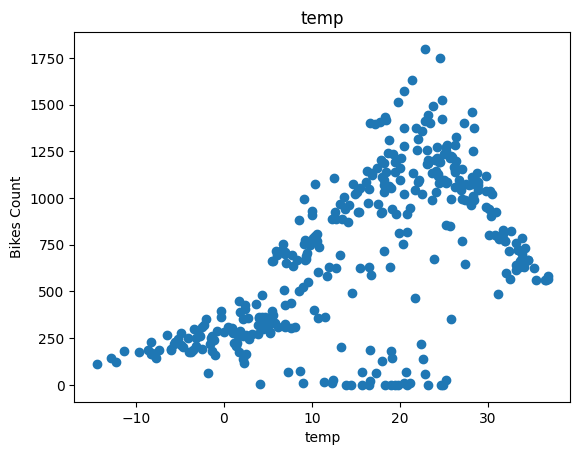

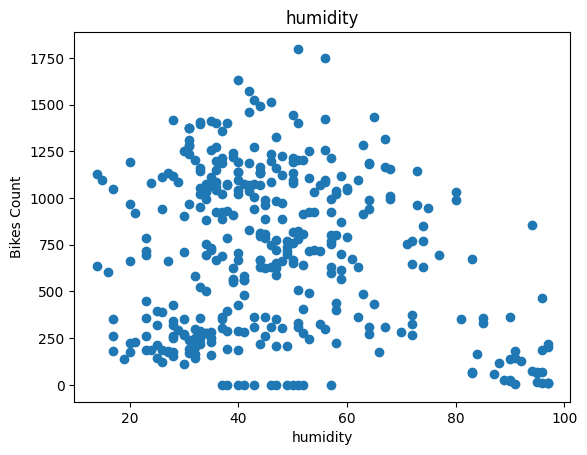

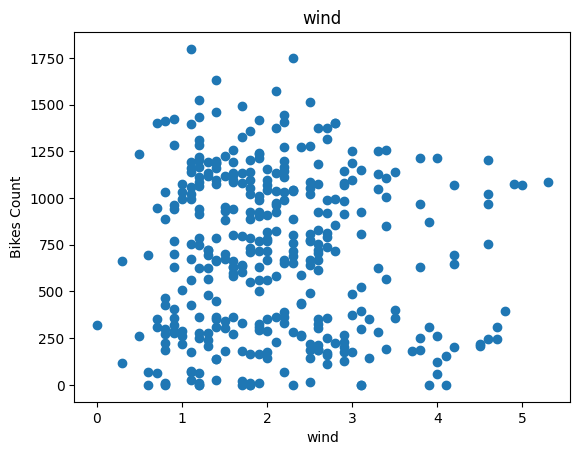

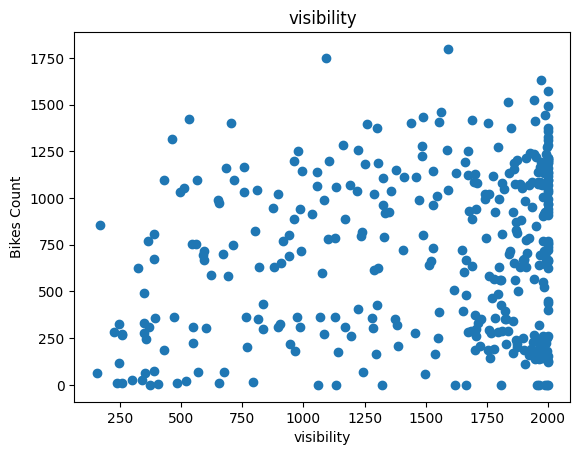

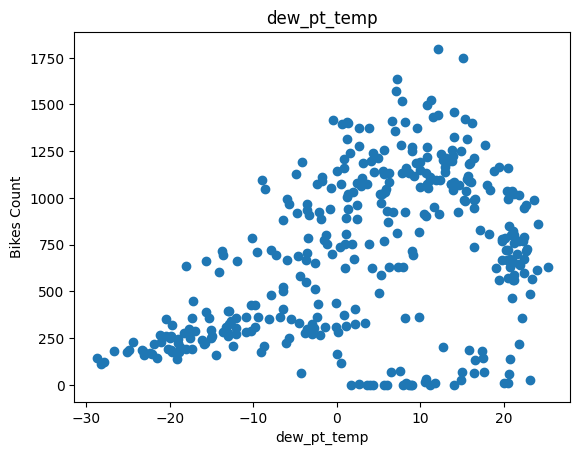

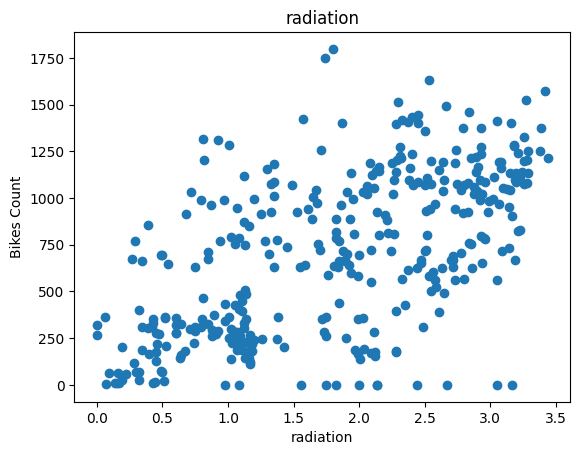

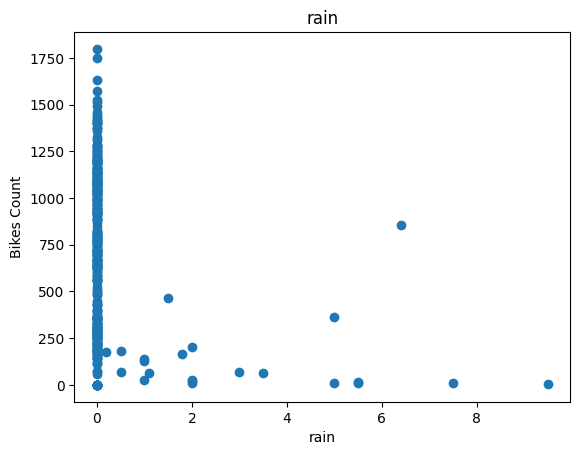

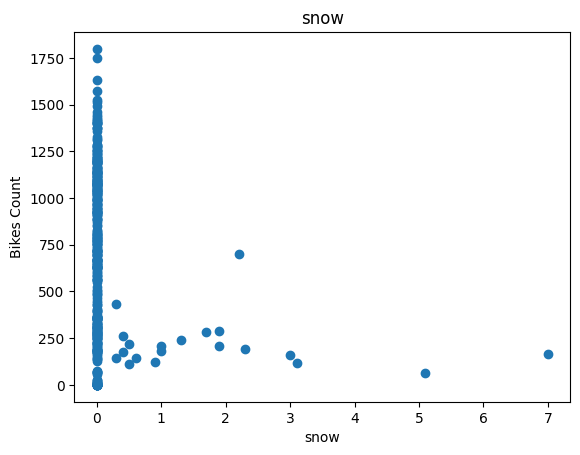

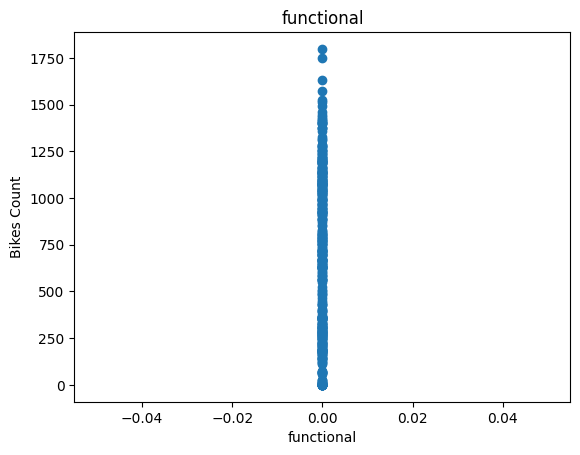

In [28]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bikes Count")
    plt.xlabel(label)
    plt.show()

In [29]:
df = df.drop(["wind", "visibility", "functional"] , axis=1)

In [30]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


Train, Valid, Test Datasets

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [46]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    
    if x_labels is None:
        x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
        
    else:
        if len(x_labels) == 1:
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            x = dataframe[x_labels].values
            
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x, y))
    
    return data, x, y

In [33]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [35]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [36]:
print(temp_reg.coef_, temp_reg.intercept_)

[[20.35926206]] [362.05127806]


In [37]:
temp_reg.score(x_test_temp, y_test_temp)

0.20393300314504026

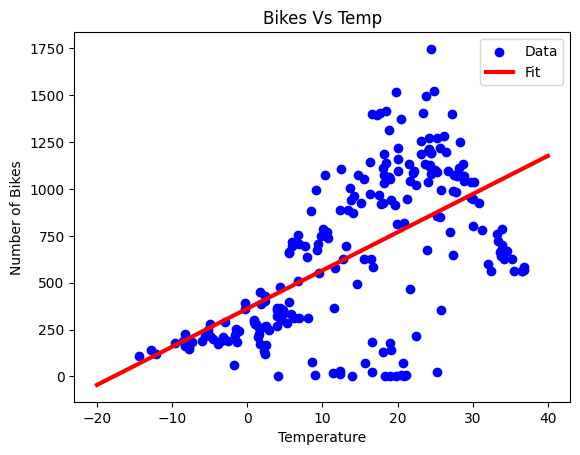

In [43]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth = 3)
plt.legend()
plt.title("Bikes Vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

Multiple Linear Regression

In [44]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [48]:
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [49]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [50]:
all_reg.score(x_test_all, y_test_all)

0.35343921443772075

In [129]:
y_pred_lr = all_reg.predict(x_test_all)

Regression with Neural Net

In [70]:

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [78]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = ('mean_squared_error')
)

In [85]:
history = temp_nn_model.fit(
    x_train_temp, y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val_temp, y_val_temp)
)


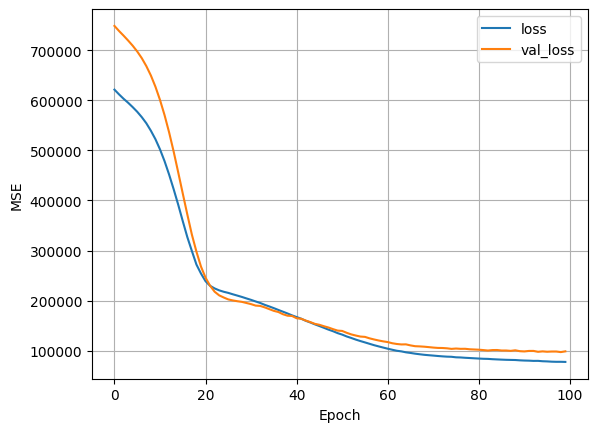

In [113]:
plot_loss(history)

In [74]:
print("x_train_temp shape:", x_train_temp.shape)

x_train_temp shape: (219, 6)


In [76]:
temp_nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),  # Match this to your x_train_temp.shape[1]
    Dense(32, activation='relu'),
    Dense(1)
])

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: x and y must be the same size

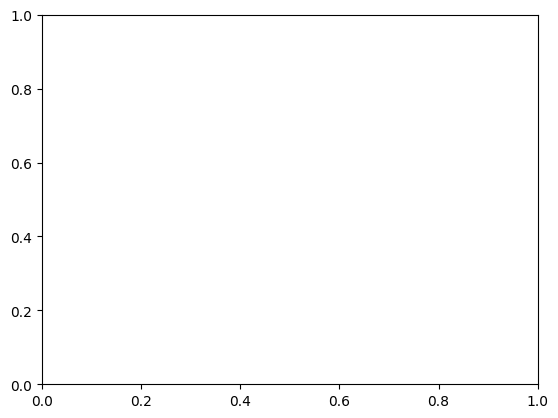

In [114]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth = 3)
plt.legend()
plt.title("Bikes Vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

In [88]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data = (x_val_temp, y_val_temp),
    verbose = 0,
    epochs = 100
)

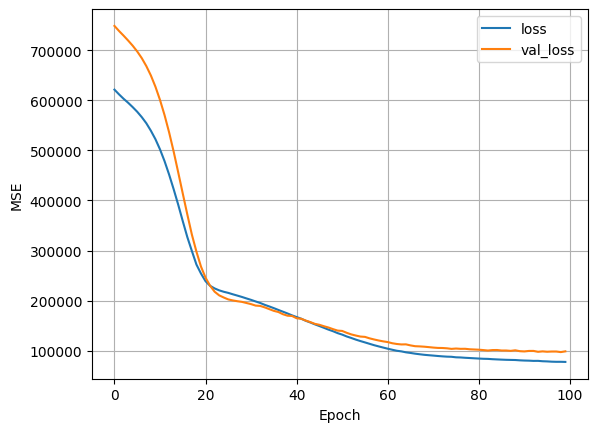

In [119]:
plot_loss(history)

In [123]:
from keras.models import Sequential
from keras.layers import Dense

nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(6,)),  # input_shape matches number of features
    Dense(32, activation='relu'),
    Dense(1)  # single output for regression
])


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [125]:
nn_model.compile(optimizer='adam', loss='mse')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step 


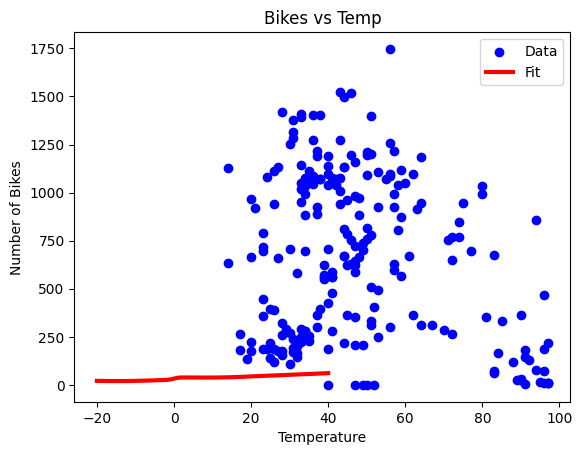

In [118]:
# Extract temperature (second column) for X-axis of the scatter plot
plt.scatter(x_train_temp[:, 1], y_train_temp, label="Data", color="blue")

# Create 100 temperature values between -20 and 40
temp_range = tf.linspace(-20., 40., 100).numpy().reshape(-1, 1)

# Create dummy input for prediction with the same number of features (6)
x_input = np.zeros((100, x_train_temp.shape[1]))  # shape = (100, 6)
x_input[:, 1] = temp_range.flatten()  # set temperature values in second column

# Predict
y_pred = nn_model.predict(x_input)

# Plot the fit
plt.plot(temp_range, y_pred, label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.xlabel("Temperature")
plt.ylabel("Number of Bikes")
plt.show()


In [120]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,1), axis=-1)
all_normalizer.adapt(x_train_all)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [121]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [126]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data = (x_val_all, y_val_all),
    verbose = 0,
    epochs = 100
)

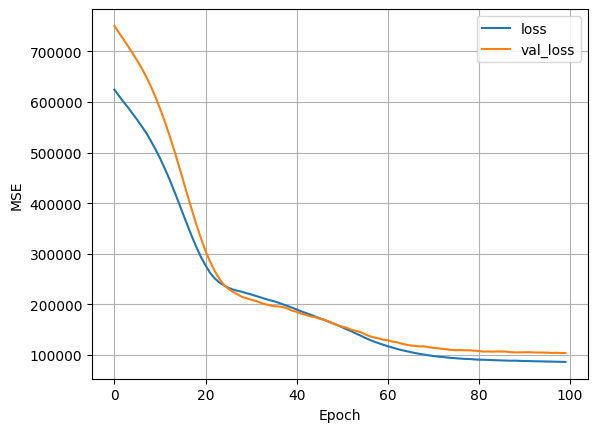

In [127]:
plot_loss(history)

In [130]:
#Calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn  = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step


In [131]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [132]:
MSE(y_pred_lr, y_test_all)

np.float64(112714.16451524773)

In [133]:
MSE(y_pred_nn, y_test_all)

np.float64(113683.19376559895)

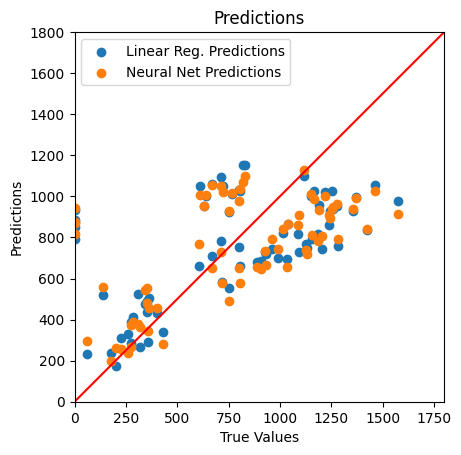

In [137]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Linear Reg. Predictions")
plt.scatter(y_test_all, y_pred_nn, label="Neural Net Predictions")
plt.title("Predictions")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims,lims,c="red")